In [1]:
import torch 
import torch_geometric
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
from dataset import *
from model import *
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cpu")

In [2]:
torch_geometric.seed_everything(23)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
carbides = MoC_c_dir(root = '/Users/ed_aguilar/Documents/PhD_Documents/Experiments/Metal_carbides/Experiments_periodicity/NewData/Data')
print("Dataset type: ", type(carbides))
print("Dataset node features: ", carbides.num_features)
print("Dataset target: ", carbides.num_classes)
print("Dataset length: ", carbides.len)
print("Dataset sample: ", carbides[0])
print("Sample  nodes: ", carbides[0].num_nodes)
print("Sample  edges: ", carbides[0].num_edges)

Dataset type:  <class 'dataset.MoC_c_dir'>
Dataset node features:  5
Dataset target:  981
Dataset length:  <bound method MoC_c_dir.len of MoC_c_dir(1046)>
Dataset sample:  Data(x=[48, 5], edge_index=[2, 658], edge_attr=[658, 6], y=[1], file_idx='1', file_name='luis_594.vasp')
Sample  nodes:  48
Sample  edges:  658


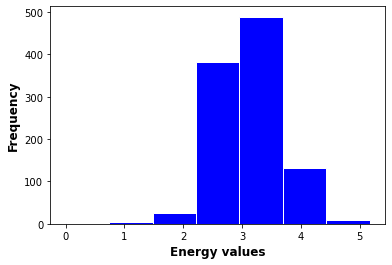

In [5]:
plt.plot(figsize =(12, 8))
plt.hist([torch.squeeze(carbides[i].y) for i in range(len(carbides))], bins = 7, color = 'blue', edgecolor='white')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.show()

In [6]:
x = [carbides[i].x.numpy() for i in range(carbides.len())]
x = np.array(x)
y = [carbides[i].y.numpy() for i in range(carbides.len())]
y = np.array(y)

In [7]:
#folds = StratifiedKFold(n_splits=5, shuffle=True)
folds = KFold(n_splits=5, shuffle=True)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, y)):
    train_idx.append(train)
    test_idx.append(test)

In [8]:
model = GCN_loop(carbides.num_features, embedding_size = 64, gnn_layers = 3, improved=False)
#model = GAT_original(data.num_features, embedding_size = 32, heads = 2)
print(model)
print(model.forward)
print("Number of parameters: ", count_parameters(model))

GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)
<bound method GCN_loop.forward of GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)>
Number of parameters:  8833


In [9]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma = 0.995)

In [10]:
kfold_idx = 0

In [11]:
train_loader = DataLoader(carbides[train_idx[kfold_idx]], batch_size = 20, shuffle = True) 
test_loader = DataLoader(carbides[test_idx[kfold_idx]], batch_size = 10, shuffle = False) 

In [12]:
train_y = [carbides[train_idx[kfold_idx]][i].y for i in range(len(carbides[train_idx[kfold_idx]]))]
test_y = [carbides[test_idx[kfold_idx]][i].y for i in range(len(carbides[test_idx[kfold_idx]]))]

print(f'The minimum training value is: {min(train_y)}, and the maximum is {max(train_y)}')
print(f'The minimum test value is: {min(test_y)}, and the maximum is {max(test_y)}')

The minimum training value is: tensor([0.], dtype=torch.float64), and the maximum is tensor([5.1534], dtype=torch.float64)
The minimum test value is: tensor([1.9593], dtype=torch.float64), and the maximum is tensor([5.1743], dtype=torch.float64)


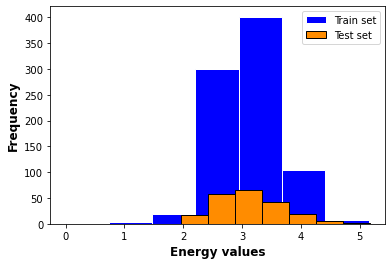

In [13]:
plt.plot(figsize = (12,8))
plt.hist(y[train_idx[kfold_idx]], 7, color = 'blue', label='Train set', edgecolor='white')
plt.hist(y[test_idx[kfold_idx]], 7, color = 'darkorange', label='Test set', edgecolor='black')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.legend()
plt.show()

In [14]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    for batch in train_loader:

        # Use GPU
        batch.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x.float(),  
                        batch.edge_index,
                        batch.batch)
        
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_y.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 


    return torch.tensor(total_loss/step), all_preds, all_labels

In [15]:
def test (epoch):
    
    all_preds = []
    all_labels = []
    total_loss = 0
    step = 0

    for batch in test_loader:

        batch.to(device)
        pred = model(batch.x.float(),  
                        batch.edge_index, 
                        batch.batch)
        
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    return torch.tensor(total_loss/step), all_preds, all_labels

In [16]:
loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

epochs = 1001

for epoch in range (epochs):
            # Training
            model.train()
            loss, pred, label = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 

            if epoch % 100 == 0:
                   print(f"Epoch {epoch} | Train Loss {loss}")
                   pred_train.append(pred)
                   labels_train.append(label)

            # Testing
            model.eval()
            if epoch % 5 == 0:
                loss, pred, label = test(epoch=epoch)
                loss = loss.detach().cpu().numpy() 

                if epoch % 10 == 0:
                    loss_test.append(loss)

                if epoch % 100 == 0:
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    pred_test.append(pred)
                    labels_test.append(label)

            scheduler.step()



Epoch 0 | Train Loss 0.653483510017395
Epoch 0 | Test Loss 0.6594856977462769
Epoch 100 | Train Loss 0.6182032823562622
Epoch 100 | Test Loss 0.5607782006263733
Epoch 200 | Train Loss 0.5708693265914917
Epoch 200 | Test Loss 0.5535270571708679
Epoch 300 | Train Loss 0.5462745428085327
Epoch 300 | Test Loss 0.5424003601074219
Epoch 400 | Train Loss 0.2557513117790222
Epoch 400 | Test Loss 0.2867180407047272
Epoch 500 | Train Loss 0.22436927258968353
Epoch 500 | Test Loss 0.24858911335468292
Epoch 600 | Train Loss 0.19432410597801208
Epoch 600 | Test Loss 0.2353670746088028
Epoch 700 | Train Loss 0.17958807945251465
Epoch 700 | Test Loss 0.23516912758350372
Epoch 800 | Train Loss 0.1749579757452011
Epoch 800 | Test Loss 0.22093114256858826
Epoch 900 | Train Loss 0.16480644047260284
Epoch 900 | Test Loss 0.21963821351528168
Epoch 1000 | Train Loss 0.1613365113735199
Epoch 1000 | Test Loss 0.21776853501796722


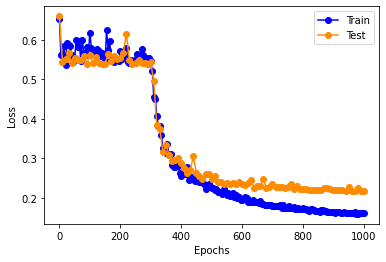

In [18]:
n=0
plt.plot(range(0,epochs,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test[n:], 'o-', label = 'Test', color = 'darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

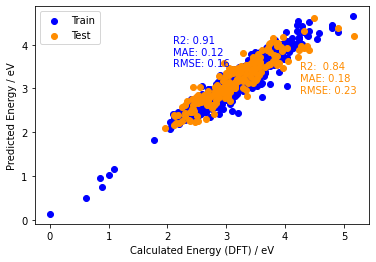

In [24]:
e = 10

plt.scatter(labels_train[e], pred_train[e], color = 'blue', label = 'Train')
plt.scatter(labels_test[e], pred_test[e], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV")
plt.ylabel("Predicted Energy / eV")
plt.legend()

plt.text(2.1, 3.5, f'R2: {pearsonr(labels_train[e], pred_train[e])[0]**2:.2f} \n\
MAE: {mean_absolute_error(labels_train[e], pred_train[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train[e], pred_train[e])):.2f}', color = 'b')

plt.text(4.25, 2.9, f'R2:  {pearsonr(labels_test[e], pred_test[e])[0]**2:.2f}\n\
MAE: {mean_absolute_error(labels_test[e], pred_test[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test[e], pred_test[e])):.2f}', color = 'darkorange')
plt.show()

In [25]:
len(train_idx[0]) + len(test_idx[0])

1046

In [26]:
def train_folds(kfold, epoch, model, optimiser, loader):

    all_preds = []
    all_y = []
    all_file = []
    total_loss = 0
    step = 0

    for batch in loader:

        # Use GPU
        batch.to(device)
        

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x.float(),  
                        batch.edge_index,
                        batch.batch)
        
        
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1
        

        all_preds.append(pred.cpu().detach().numpy())
        all_y.append(batch.y.cpu().detach().numpy())
        all_file.append(batch.file_name)
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    all_file = np.concatenate(all_file).ravel()
    
    return torch.tensor(total_loss/step), all_preds, all_labels, all_file

In [27]:
def test_folds(kfold, epoch, model, loader):
    
    all_preds = []
    all_labels = []
    all_file = []
    total_loss = 0
    step = 0

    for batch in loader:

        batch.to(device)
        pred = model(batch.x.float(),  
                        batch.edge_index, 
                        batch.batch)
        
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
        all_file.append(batch.file_name)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    all_file = np.concatenate(all_file).ravel()

    return torch.tensor(total_loss/step), all_preds, all_labels, all_file

In [28]:
epochs = 1201

#folds x times loss is saved
loss_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
loss_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#times preds are saved x number of predictions x folds
pred_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
pred_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
labels_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
labels_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times file are saved x number of predictions x folds
file_train_folds = [[[None] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
file_test_folds = [[[None] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 

In [29]:
for fold in range(len(train_idx)):

    model = GCN_loop(carbides.num_features, embedding_size = 64, gnn_layers = 3, improved=False)
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma = 0.995)
    train_loader = DataLoader(carbides[train_idx[fold]], batch_size = 20, shuffle = True) 
    test_loader = DataLoader(carbides[test_idx[fold]], batch_size = 10, shuffle = False) 


    for epoch in range (epochs):

        # Training
        model.train()
        loss, pred, label, file = train_folds(kfold = fold, 
                                        epoch=epoch, 
                                        model = model, 
                                        optimiser = optimiser, 
                                        loader = train_loader)
        
        
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train_folds[fold, int(epoch / 5)] = loss

        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Fold {fold} | Train Loss {loss}")
            pred_train_folds[fold][:, int(epoch/5)] = pred
            labels_train_folds[fold][:, int(epoch/5)] = label
            file_train_folds[fold][int(epoch/5)] = file


        # Testing
        model.eval()

        if epoch % 5 == 0:
            loss, pred, label, file = test_folds(kfold = fold, 
                                           epoch=epoch, 
                                           model=model,
                                           loader = test_loader)
            loss = loss.detach().cpu().numpy() 

            if epoch % 5 == 0:
                loss_test_folds[fold, int(epoch / 5)] = loss

            if epoch % 5 == 0:
                print(f"Epoch {epoch} | Fold {fold} | Test Loss {loss}")
                pred_test_folds[fold][:, int(epoch/5)] = pred
                labels_test_folds[fold][:, int(epoch/5)] = label
                file_test_folds[fold][int(epoch/5)] = file
        
        scheduler.step()
    
    print(f'Done for fold {fold}')

Epoch 0 | Fold 0 | Train Loss 0.653483510017395
Epoch 0 | Fold 0 | Test Loss 0.6594856977462769
Epoch 5 | Fold 0 | Train Loss 0.5603123903274536
Epoch 5 | Fold 0 | Test Loss 0.6030579805374146
Epoch 10 | Fold 0 | Train Loss 0.5651590824127197
Epoch 10 | Fold 0 | Test Loss 0.5432875156402588
Epoch 15 | Fold 0 | Train Loss 0.5841408371925354
Epoch 15 | Fold 0 | Test Loss 0.5794506669044495
Epoch 20 | Fold 0 | Train Loss 0.5370587110519409
Epoch 20 | Fold 0 | Test Loss 0.5505003333091736
Epoch 25 | Fold 0 | Train Loss 0.5906295776367188
Epoch 25 | Fold 0 | Test Loss 0.6217747330665588
Epoch 30 | Fold 0 | Train Loss 0.5874932408332825
Epoch 30 | Fold 0 | Test Loss 0.5666022896766663
Epoch 35 | Fold 0 | Train Loss 0.585177481174469
Epoch 35 | Fold 0 | Test Loss 0.547957718372345
Epoch 40 | Fold 0 | Train Loss 0.561534583568573
Epoch 40 | Fold 0 | Test Loss 0.5411474108695984
Epoch 45 | Fold 0 | Train Loss 0.5435226559638977
Epoch 45 | Fold 0 | Test Loss 0.532480776309967
Epoch 50 | Fold 0 |

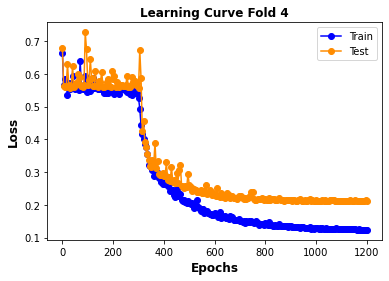

In [50]:
n=0
fold = 4

plt.plot(figsize =(3, 2))

plt.title(f'Learning Curve Fold {fold}', fontweight ='bold')

plt.plot(range(0,epochs,5)[n:], loss_train_folds[fold, n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,5)[n:], loss_test_folds[fold, n:], 'o-', label = 'Test', color = 'darkorange')
plt.xlabel('Epochs', fontweight ='bold', fontsize = 12)
plt.ylabel('Loss', fontweight ='bold', fontsize = 12)
plt.legend()
plt.show()

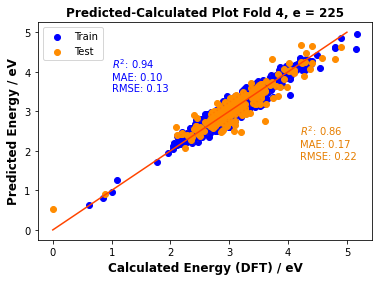

In [82]:
e = 225
fold =4

true_train = labels_train_folds[fold][:, e]
predicted_train = pred_train_folds[fold][:, e]
true_test = labels_test_folds[fold][:, e]
predicted_test = pred_test_folds[fold][:, e]


plt.plot(figsize =(6, 4))

plt.title(f'Predicted-Calculated Plot Fold {fold}, e = {e}', fontweight ='bold')

plt.plot( [2, 4],[2+.23, 4+.23], color = 'orangered', ls = ':', alpha = .2 )

plt.plot( [0, 5],[0, 5], color = 'orangered' )

plt.plot( [2+.23, 4+.23],[2, 4], color = 'orangered', ls = ':', alpha = .2 )

plt.scatter(true_train, predicted_train, color = 'blue', label = 'Train')
plt.scatter(true_test , predicted_test, color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV", fontweight ='bold', fontsize = 12)
plt.ylabel("Predicted Energy / eV", fontweight ='bold', fontsize = 12)
plt.legend()



plt.text(1, 3.5, f'$R^2$: {r2_score(true_train,predicted_train):.2f} \n\
MAE: {mean_absolute_error(true_train, predicted_train):.2f} \n\
RMSE: {sqrt(mean_squared_error(true_train, predicted_train)):.2f}', color = 'b')

plt.text(4.2, 1.8, f'$R^2$: {r2_score(true_test, predicted_test):.2f} \n\
MAE: {mean_absolute_error(true_test, predicted_test):.2f} \n\
RMSE: {sqrt(mean_squared_error(true_test, predicted_test)):.2f}', color = '#e67e00')

plt.show()

In [28]:
e = 7
fold = 2

r_train = labels_train_folds[e,:,fold]
p_train = pred_train_folds[e,:,fold]
grad = pred_train_folds[e,:,fold] - labels_train_folds[e,:,fold]
files_train = file_train_folds[e,:,fold]

train_trace = go.Scatter(x=r_train,
                         y=p_train,
                         mode='markers',
                         name= 'Train set',
                         opacity=.7, 
                         hovertemplate = 
                         'Predicted: %{y:.2f}'+
                        '<br>Calculated: %{x:.2f}<br>'+
                        '%{text}',
                        text = ['File: {}.vasp'.format(int(i)) for i in files_train],
                         marker=dict(symbol='circle',
                                     size=5,
                                     color='black')
                            )


r_test = labels_test_folds[e,:,fold]
p_test = pred_test_folds[e,:,fold]
grad = pred_test_folds[e,:,fold] - labels_test_folds[e,:,fold]
files_test = file_test_folds[e,:,fold]

test_trace = go.Scatter(x=r_test,
                         y=p_test,
                         mode='markers',
                         name= 'Test set',
                         hovertemplate = 
                         '<i>Predicted</i>: %{y:.2f}'+
                        '<br>Calculated: %{x:.2f}<br>'+
                        '%{text}',
                        text = ['File: {}.vasp'.format(int(i)) for i in files_test],

                         marker=dict(symbol='circle',
                                     size=5,
                                     color=-abs(grad),
                                     colorscale='Hot')
                            )


trace_edges= go.Scatter(x=[min(labels_train_folds[e,:,fold]), max(labels_train_folds[e,:,fold])],
                        y=[min(labels_train_folds[e,:,fold]), max(labels_train_folds[e,:,fold])],
                        text='Identity line',
                        mode='lines',
                        name='Identity',
                        line=dict(color='black', width=1,dash='dash'),
                        hoverinfo='none')

traces = [train_trace, test_trace, trace_edges]

fig = go.Figure(data=traces)

fig.update_xaxes(title_text="Calculated DFT Energy / eV")
fig.update_yaxes(title_text="Predicted Energy / eV")

fig.update_layout(autosize=False,
    width=900,
    height=600, 
    template = 'none')

fig.show()

In [32]:
r2_global_test = []
for e in range(len(range(0,epochs,5))):
    r2_test = [r2_score(labels_test_folds[f][:, e], pred_test_folds[f][:, e])
                  for f in range(len(train_idx))]
    r2_global_test.append(r2_test)
    
mae_global_test = []
for e in range(len(range(0,epochs,5))):
    mae_test = [mean_absolute_error(labels_test_folds[f][:, e], pred_test_folds[f][:, e])
                  for f in range(len(train_idx))]
    mae_global_test.append(mae_test)

rmse_global_test = []
for e in range(len(range(0,epochs,5))):
    rmse_test = [sqrt(mean_squared_error(labels_test_folds[f][:, e], pred_test_folds[f][:, e]))
                  for f in range(len(train_idx))]
    rmse_global_test.append(rmse_test)

In [33]:
mean_r2_test = []
std_r2_test = []

mean_mae_test = []
std_mae_test = []

mean_rmse_test = []
std_rmse_test = []

for i in range(len(range(0,epochs,5))):

    mean_r2_test.append(np.mean(r2_global_test[i]))
    std_r2_test.append(np.std(r2_global_test[i]))

    mean_mae_test.append(np.mean(mae_global_test[i]))
    std_mae_test.append(np.std(mae_global_test[i]))

    mean_rmse_test.append(np.mean(rmse_global_test[i]))
    std_rmse_test.append(np.std(rmse_global_test[i]))

In [34]:
print(f'e value for best R2: {mean_r2_test.index(max(mean_r2_test))}')
print(f'e value for best MAE: {mean_mae_test.index(min(mean_mae_test))}')
print(f'e value for best RMSE: {mean_rmse_test.index(min(mean_rmse_test))}')

e value for best R2: 225
e value for best MAE: 224
e value for best RMSE: 225


In [45]:
all = [sum(x) for x in zip(mean_mae_test, mean_rmse_test)]
all_std = [sum(x) for x in zip(std_mae_test, std_rmse_test)]
all_ms = [x*y for x,y in zip(all, all_std)]
all_sum_std = [x+y for x,y in zip(all, all_std)]
print(f'e value for best General with std mul: {all_ms.index(min(all_ms))}')
print(f'e value for best General with std sum: {all_sum_std.index(min(all_sum_std))}')
print(f'e value for best General no std: {all.index(min(all))}')

e value for best General with std mul: 166
e value for best General with std sum: 221
e value for best General no std: 225


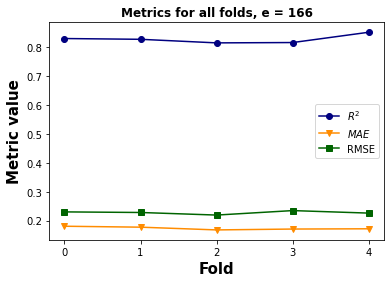

In [56]:
e = 166
plt.plot(figsize =(6, 4))

plt.title(f'Metrics for all folds, e = {e}', fontweight ='bold')

plt.plot(range(len(train_idx)), r2_global_test[e], 'o-', label = '$R^2$', color = 'navy')
plt.plot(range(len(train_idx)), mae_global_test[e], 'v-', label = '$MAE$', color = 'darkorange')
plt.plot(range(len(train_idx)), rmse_global_test[e], 's-', label = 'RMSE', color = 'darkgreen')
plt.xticks(range(len(train_idx)), range(5))

plt.xlabel('Fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

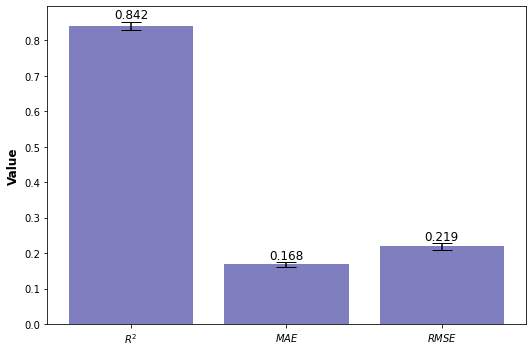

[0.011325008951905817, 0.007368319230347939, 0.00966257103837577]


In [85]:
e=225

Metrics = ['$R^2$', '$MAE$', '$RMSE$']
x_pos = np.arange(len(Metrics))
CTEs = [mean_r2_test[e], mean_mae_test[e], mean_rmse_test[e]]
error = [std_r2_test[e], std_mae_test[e], std_rmse_test[e]]
CTEs = [round(metric, 3) for metric in CTEs]

fig, ax = plt.subplots(figsize =(7.5, 5))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars, fontsize = 12)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()
print(error)

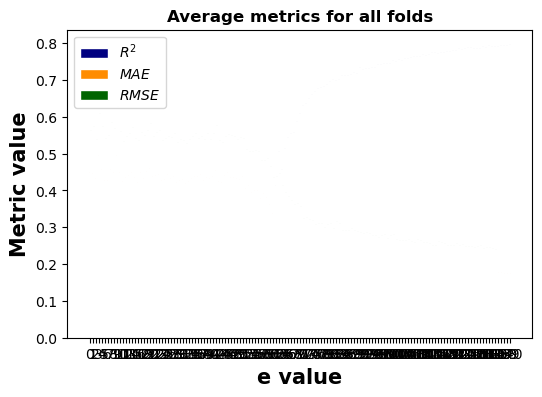

In [64]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))

plt.title(f'Average metrics for all folds', fontweight ='bold')

# set height of bar
R2 = mean_r2_test
MAE = mean_mae_test
RMSE = mean_rmse_test
 
# Set position of bar on X axis
br1 = np.arange(len(R2))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, R2, color ='navy', width = barWidth,
        edgecolor ='white', label ='$R^2$')
plt.bar(br2, MAE, color ='darkorange', width = barWidth,
        edgecolor ='white', label ='$MAE$')
plt.bar(br3, RMSE, color ='darkgreen', width = barWidth,
        edgecolor ='white', label ='$RMSE$')
 
# Adding Xticks
plt.xlabel('e value', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(R2))],
        [i for i in range(len(R2))])
 
plt.legend()
plt.show()

In [33]:
best_r2 = r2_global_test[e]
best_mae = mae_global_test[e]
best_rmse = rmse_global_test[e]

In [34]:
df = pd.DataFrame(list(zip(best_r2, best_mae, best_rmse)), columns = ['R2', 'MAE', 'RMSE'])
max = pd.DataFrame(np.transpose(np.array(df.max()))).T
max.columns = df.columns
max = max.rename(index={0:'Max'})
min = pd.DataFrame(np.transpose(np.array(df.min()))).T
min.columns = df.columns
min = min.rename(index={0:'Min'})
mean = pd.DataFrame(np.transpose(np.array(df.mean()))).T
mean.columns = df.columns
mean = mean.rename(index={0:'Mean'})
std = pd.DataFrame(np.transpose(np.array(df.std()))).T
std.columns = df.columns
std = std.rename(index={0:'Std'})
df = pd.concat([df,max,min,mean,std], axis = 0)
df.index.name = 'fold'
df

,R2,MAE,RMSE
fold,,,
0,0.797409,0.184272,0.231781
1,0.825882,0.162187,0.225093
2,0.855002,0.146768,0.189270
3,0.824536,0.161909,0.219042
4,0.777216,0.192030,0.253258
Max,0.855002,0.192030,0.253258
Min,0.777216,0.146768,0.189270
Mean,0.816009,0.169433,0.223689
Std,0.029755,0.018396,0.023173
